# Break Through Tech - Allstate Team 1b
## Author: Minh Le
---

This file is used to build a Generalized Linear Model (GLM) from the dataset given by Allstate.

### 1. Import Libraries and Dataset

In [25]:
import pandas as pd
from patsy import dmatrices
import numpy as np
import statsmodels.api as sm
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.compat import lzip
from statsmodels.graphics.api import abline_plot
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv('../data/claims_data.csv')
df.head()

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,1,A,B,A,B,A,A,A,A,B,...,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,2,A,B,A,A,A,A,A,A,B,...,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,5,A,B,A,A,B,A,A,A,B,...,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,10,B,B,A,B,A,A,A,A,B,...,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
4,11,A,B,A,B,A,A,A,A,B,...,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85


Since the idea here is to use GLM, we need to know the distribution of the response variable. I will start by plotting out the distribution of the response variable (`loss`). 

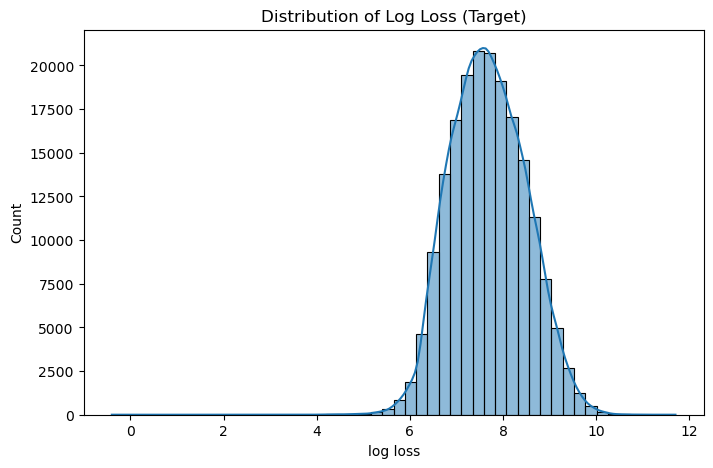

In [5]:
df['log loss'] = np.log(df['loss'])
plt.figure(figsize=(8,5))
sns.histplot(df['log loss'], bins=50, kde=True)
plt.title("Distribution of Log Loss (Target)")
plt.show()

The claim severity is highly skewed (right-skewed). Therefore, I will start by building a model with gamma distribution.

In [18]:
categorical_cols = [c for c in df.columns if c.startswith("cat") and df[c].nunique() == 2]
continuous_cols = [c for c in df.columns if c.startswith("cont")]
df_selected = df[categorical_cols + continuous_cols + ['loss']]

In [19]:
from sklearn.preprocessing import OneHotEncoder

# Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit and transform the 'City' column
encoded_data = encoder.fit_transform(df_selected[categorical_cols])

In [20]:
# Create a DataFrame from the encoded data
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_cols))

# Combine with original DataFrame (optional)
df_final = pd.concat([df_selected, encoded_df], axis=1).drop(categorical_cols, axis=1)
df_final

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,...,cat68_A,cat68_B,cat69_A,cat69_B,cat70_A,cat70_B,cat71_A,cat71_B,cat72_A,cat72_B
0,0.726300,0.245921,0.187583,0.789639,0.310061,0.718367,0.335060,0.30260,0.67135,0.83510,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,0.330514,0.737068,0.592681,0.614134,0.885834,0.438917,0.436585,0.60087,0.35127,0.43919,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,0.261841,0.358319,0.484196,0.236924,0.397069,0.289648,0.315545,0.27320,0.26076,0.32446,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,0.321594,0.555782,0.527991,0.373816,0.422268,0.440945,0.391128,0.31796,0.32128,0.44467,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,0.273204,0.159990,0.527991,0.473202,0.704268,0.178193,0.247408,0.24564,0.22089,0.21230,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188313,0.347403,0.785784,0.613660,0.473202,0.939556,0.242437,0.289949,0.24564,0.30859,0.32935,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
188314,0.507661,0.555782,0.549770,0.802892,0.704268,0.334270,0.382000,0.63475,0.40455,0.47779,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
188315,0.484469,0.785784,0.792378,0.189137,0.482436,0.345883,0.370534,0.24564,0.45808,0.47779,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
188316,0.438385,0.422197,0.298977,0.383428,0.340543,0.704364,0.562866,0.34987,0.44767,0.53881,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [23]:
# Create a dataframe of the features
df_features = df_final.drop(columns = ['loss'])

# Create a dataframe of the target variable
df_target = df_final['loss']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_features, df_target, test_size=0.3, random_state=42)

# Create an instance of Elastic Net Regression
enet = ElasticNet(alpha=0.5, l1_ratio=0.5)

# Fit the model to the training data
enet.fit(X_train, y_train)

# Predict the target variable using the testing data
y_pred = enet.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 5980366.473730668


In [26]:
print(f"R-squared: {r2_score(y_test, y_pred)}")

R-squared: 0.28001637628583376
